### Objectives

1. Download, merge, and describe the dataset and its basic characteristics (e.g., shape,
variable types, basic stats).
2. Choose several variables and create visualizations to show their distributions. Justify
your variable selection.
3. Clean the dataset to handle any missing data and justify your decisions.
4. For building a model, would you rescale any data in this dataset? How and why or
why not?
5. Build a model to identify risk factors for diabetes. Explain your choice of model and
what it can predict. What metrics would you use to assess performance? For this
dataset, how would you know your model is adequate?
6. Using these data, what are some identifiable risk factors for diabetes? How do you
know? Explain as if you were reporting the results to a non-technical stakeholder.

### Code

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
def get_min_max(df, do_print=True):
    ranges = [
        {"name": col, "min": df[col].min(), "max": df[col].max()} for col in df.columns
    ]

    if do_print:
        print(ranges)

    else:
        return ranges

# 1. 

## 1a. Download

In [5]:
dc = pd.read_csv("dataCategorical.csv")
dn = pd.read_csv("dataNumeric.csv")
do = pd.read_csv("dataOrdinal.csv")

In [6]:
#drop duplicate columns
dc.drop(columns=["DIABETE3.1", "MARITAL.1"], inplace=True)

In [ ]:
# dc["HLTHPLN1"].value_counts()

## 1b. Merge

In [8]:
dc_dn = dc.merge(dn, how="inner")
alldf = dc_dn.merge(do, how="inner")
alldf.set_index("PERSONID", inplace=True)

In [9]:
# copy of data without Categorical types to use for correlation
alldf_tmp = alldf.copy()

In [10]:
cat_columns = list(dc.columns[1:])
cat_columns.extend(
    ["GENHLTH", "_AGEG5YR", "_BMI5CAT", "CHECKUP1", "INCOME2", "_EDUCAG", "_SMOKER3"]
)

for c in cat_columns:
    alldf[c] = pd.Categorical(alldf[c])

## 1c. Describe the dataset and its basic characteristics (e.g., shape, variable types, basic stats)

### Original version

In [ ]:
alldf.head()

In [ ]:
alldf.shape

In [ ]:
alldf.info()

In [ ]:
alldf.describe()

### Cleaned version

#### Clean dataset

1. Drop NA/missing/refused/do not know/not sure values

In [11]:
def drop_missing(df, print_col=None):
    """
    drop BLANK/missing/refused/don't know/not sure values - inferred from the variable dictionary - from each column
    """
    drop_vals = {
        # "PERSONID": [],
        "DIABETE3": [7, 9],
        "_RACE": [9],
        # "MSCODE": [],
        "EMPLOY1": [9],
        # "SEX": [],
        "MARITAL": [9],
        "RENTHOM1": [7, 9],
        # "_STATE": [],
        # "NUMADULT": [],
        "CHILDREN": [99],
        "INCOME2": [77, 99],
        "_EDUCAG": [9],
        "WEIGHT2": [7777, 9999],
        "FLUSHOT6": [7, 9],
        "CVDCRHD4": [7, 9],
        "HLTHCVR1": [77, 99],
        "CHCKIDNY": [7, 9],
        "USEEQUIP": [7, 9],
        "_TOTINDA": [9],
        "ADDEPEV2": [7, 9],
        "EXERANY2": [7, 9],
        "BLIND": [7, 9],
        "DECIDE": [7, 9],
        "HLTHPLN1": [7, 9],
        "ASTHMA3": [7, 9],
        "DRVISITS": [77],
        "GENHLTH": [7, 9],
        "_AGEG5YR": [14],
        # "_BMI5CAT": [],
        "CHECKUP1": [7, 9],
        "SLEPTIM1": [77, 99],
        "MENTHLTH": [77, 99],
        "_SMOKER3": [9],
    }

    for col, v in drop_vals.items():
        df = df[~df[col].isin(v)]
        if print_col:
            print(
                f"\n\ncol = {col}-------\ndf[{print_col}].value_counts():\n{df[print_col].value_counts()}"
            )

    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

**NOTE:** HLTHPLN1 becomes NaN in corr() because I'm dropping rows with "missing"/"refused"/"do not know" values. Perhaps there's a better way to address these types of values than just deleting the full row?

In [12]:
alldf_tmp = drop_missing(alldf_tmp, print_col="HLTHPLN1")



col = DIABETE3-------
df[HLTHPLN1].value_counts():
HLTHPLN1
1.0    4615
2.0     358
9.0      12
7.0       8
Name: count, dtype: int64


col = _RACE-------
df[HLTHPLN1].value_counts():
HLTHPLN1
1.0    4528
2.0     353
9.0      11
7.0       8
Name: count, dtype: int64


col = EMPLOY1-------
df[HLTHPLN1].value_counts():
HLTHPLN1
1.0    4514
2.0     348
9.0       9
7.0       8
Name: count, dtype: int64


col = MARITAL-------
df[HLTHPLN1].value_counts():
HLTHPLN1
1.0    4498
2.0     345
9.0       9
7.0       7
Name: count, dtype: int64


col = RENTHOM1-------
df[HLTHPLN1].value_counts():
HLTHPLN1
1.0    4467
2.0     342
9.0       9
7.0       6
Name: count, dtype: int64


col = CHILDREN-------
df[HLTHPLN1].value_counts():
HLTHPLN1
1.0    4458
2.0     341
9.0       8
7.0       6
Name: count, dtype: int64


col = INCOME2-------
df[HLTHPLN1].value_counts():
HLTHPLN1
1.0    3858
2.0     303
9.0       5
7.0       3
Name: count, dtype: int64


col = _EDUCAG-------
df[HLTHPLN1].value_counts():
HL

2. Make WEIGHT2 as one metric
   1. Arbitrarily chose pounds
   2. 1 kg = 2.2 lbs
   3. 9000 - 9998 is kg without first 9. Ex: 9139 = 139kg

In [13]:
alldf_tmp.loc[alldf_tmp["WEIGHT2"] > 999, "WEIGHT2"] -= 9000 #get kg
alldf_tmp.loc[alldf_tmp["WEIGHT2"] > 999, "WEIGHT2"] /= 2.2 #kg -> lbs

1. Reduce DIABETE3 to 0 = negative diagnosis 1 = positive diagnosis as nuances don't matter, only whether someone has a positive/negative diagnosis
   1. 1 and 2 = Yes, 3 and 4 = No

In [14]:
alldf_tmp["DIABETE3"] = np.where(alldf_tmp["DIABETE3"] < 3, 1, 0)

4. Turn MENTHLTH, DRVISITS, CHILDREN value 88 to 0
   1. 88 means "None" for these columns

In [15]:
for col in ["MENTHLTH", "DRVISITS", "CHILDREN"]:
    alldf_tmp[col].replace({88: 0}, inplace=True)

In [16]:
alldf_tmp["HLTHPLN1"].value_counts()

HLTHPLN1
1.0    1564
Name: count, dtype: int64

### new dataset shape, variable types, and basic stats

In [17]:
alldf_new = alldf_tmp.copy()

for c in cat_columns:
    alldf_new[c] = pd.Categorical(alldf_new[c])

In [ ]:
alldf_new.shape

In [ ]:
alldf_new.info()

In [ ]:
alldf_new.describe()

# 2.

## Basic Distribution Visualizations

### 2a. Choose several variables

In [22]:
variables = alldf_new.columns

### 2b Create visualizations to show their distributions.

Text(0.5, 1.0, 'Diabetes Distribution')

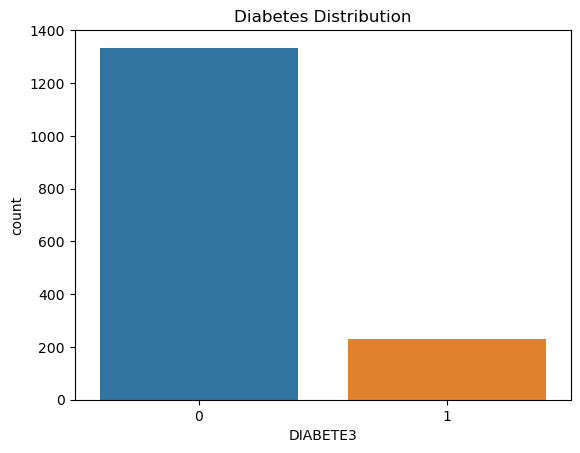

In [25]:
# make target variable distribution

sns.countplot(x="DIABETE3", data=alldf_new)
plt.title("Diabetes Distribution")

# it's an imbalanced distribution

In [26]:
custom_plots = {
    "_RACE": {
        "labels": {
            1: "White",
            2: "Black",
            3: "Am. Indian",
            4: "Asian",
            5: "Pacific",
            6: "Other",
            7: "Multiracial",
            8: "Hispanic",
            9: "Not Sure",
        },
        "figsize": None,
    },
    "SEX": {"labels": {1: "Male", 2: "Female"}, "figsize": None},
    "_STATE": {"labels": None, "figsize": (12, 5)},
    "DRVISITS": {"labels": None, "figsize": (12, 5)},
}

In [29]:
# def graph(variable, df=alldf_new, figsize=None, labels=None):
#     var_df = df.copy()

#     if labels:
#         var_df[variable] = df[variable].replace(labels)

#     var_df.groupby(variable)["DIABETE3"].value_counts(normalize=True).unstack().plot(
#         kind="bar", figsize=figsize, title=f"Diabetes Distribution over {variable}"
#     )
    
def graph(variable, df=alldf_new, figsize=None, labels=None):
    var_df = df.copy()

    if labels:
        var_df[variable] = df[variable].replace(labels)

    try:
        data = var_df.groupby(variable)["DIABETE3"].value_counts(normalize=True).unstack()
        if data.empty:
            print(f"No data available for {variable}")
            return
        data.plot(kind="bar", figsize=figsize, title=f"Diabetes Distribution over {variable}")
    except Exception as e:
        print(f"Error: {e}")


Error: zero-size array to reduction operation maximum which has no identity


C:\Users\HP\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:509: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


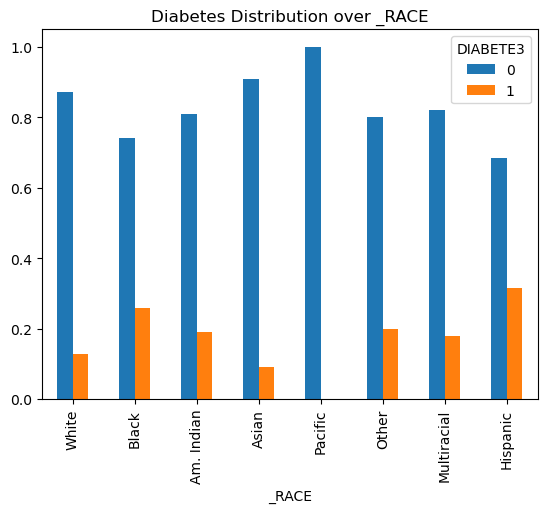

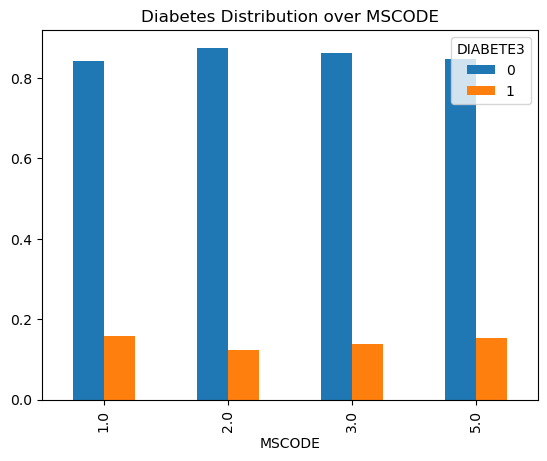

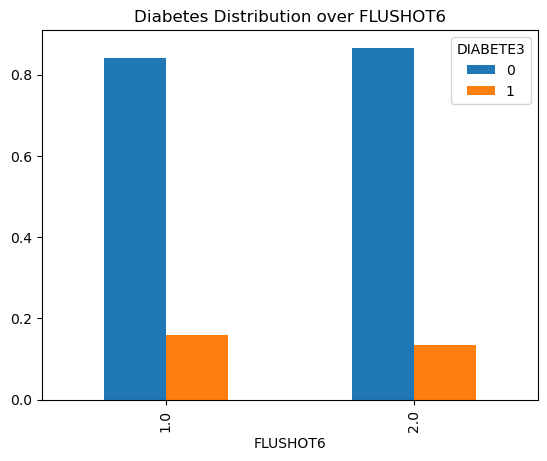

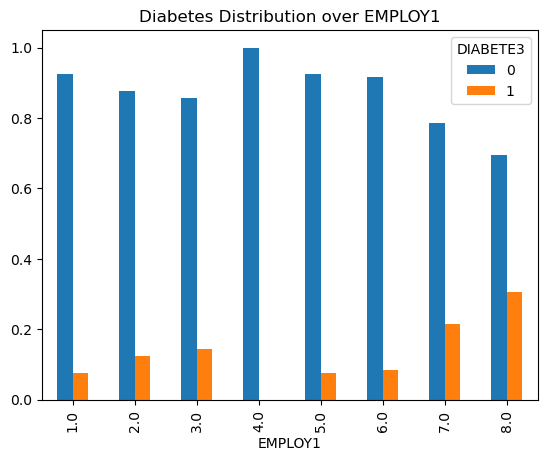

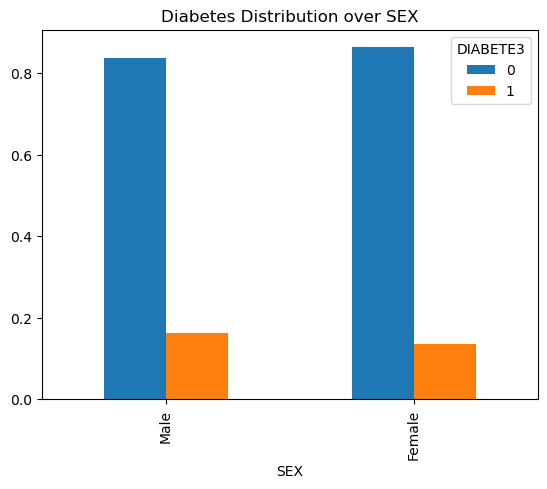

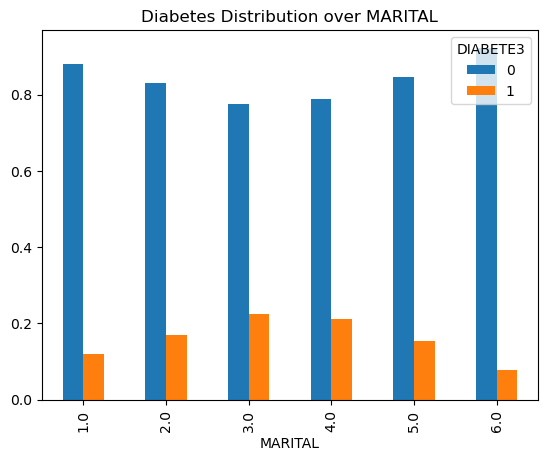

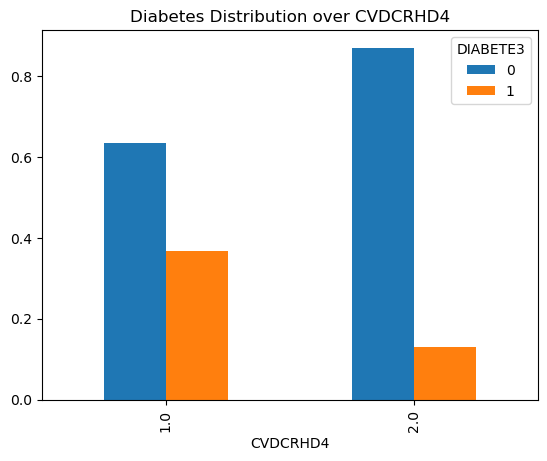

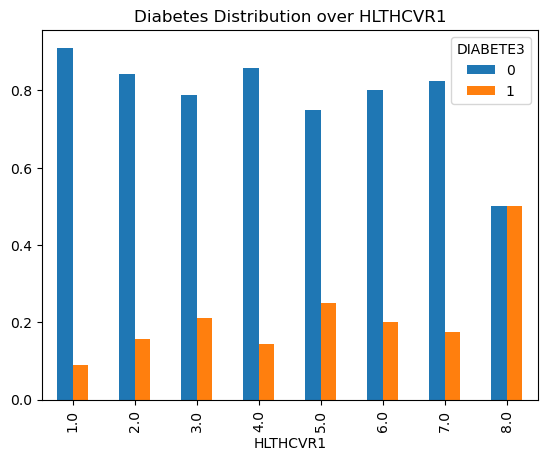

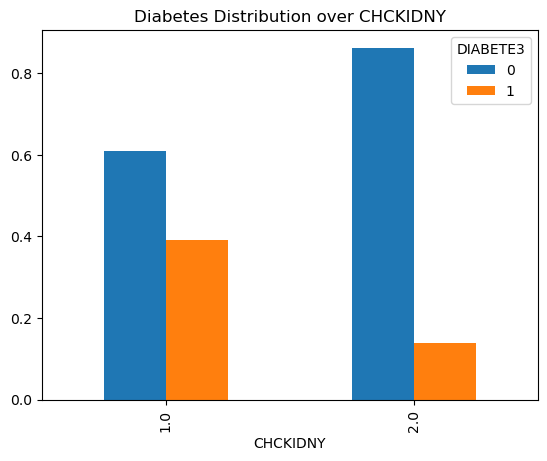

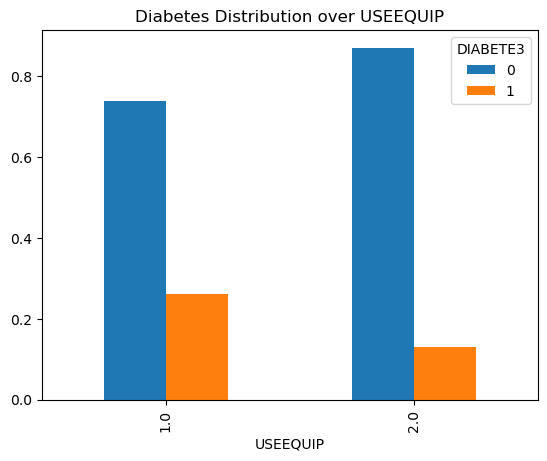

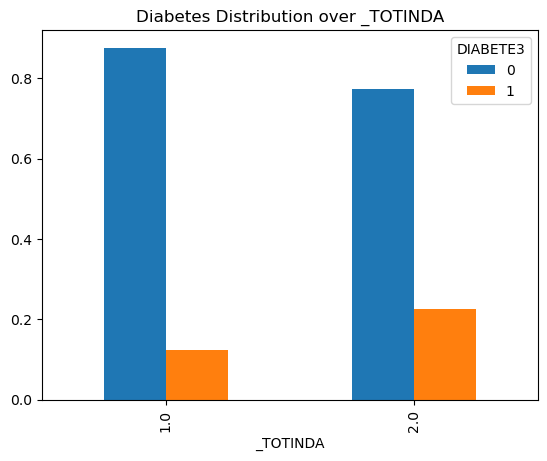

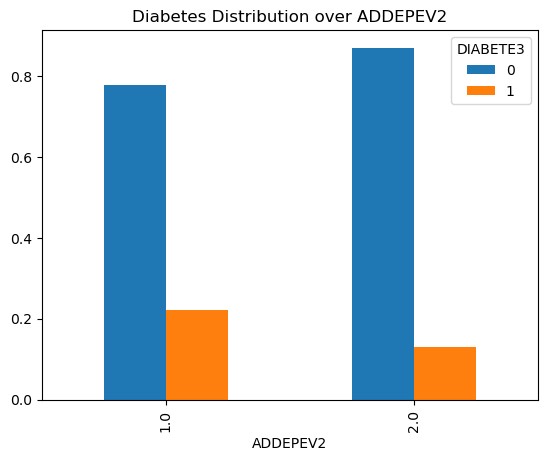

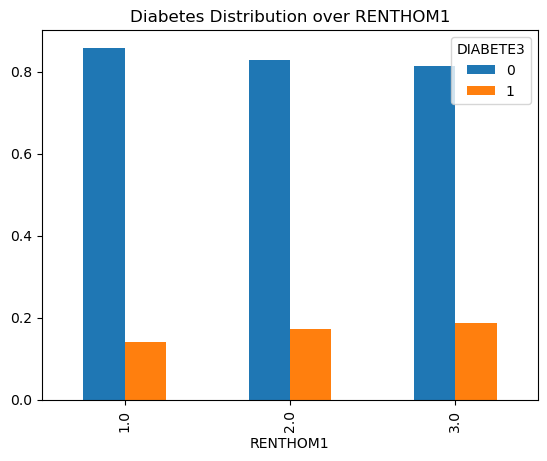

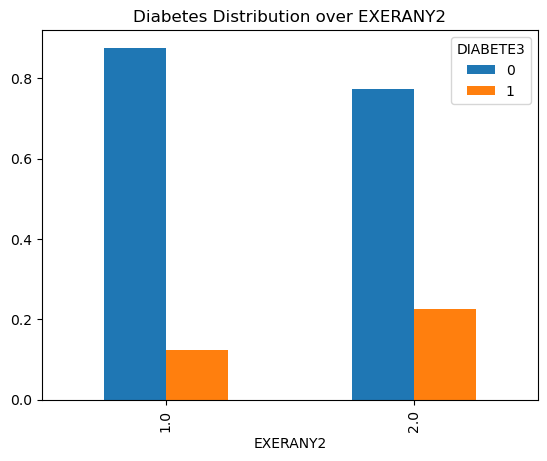

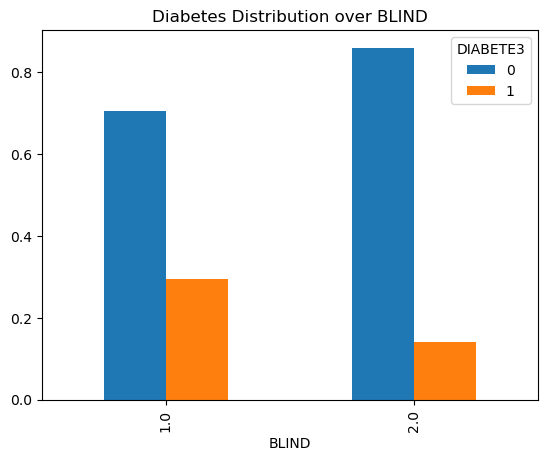

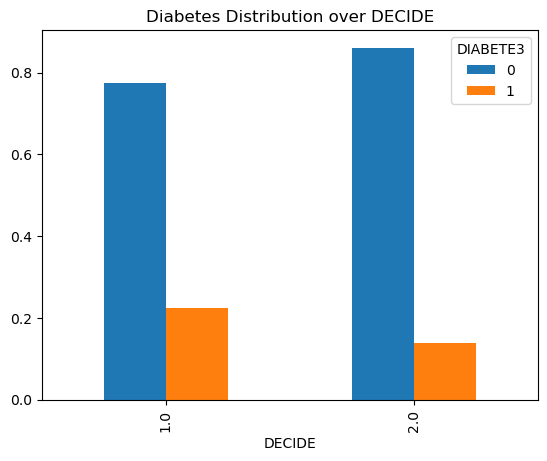

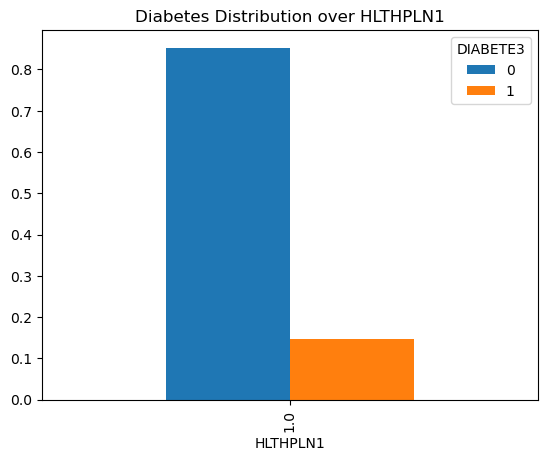

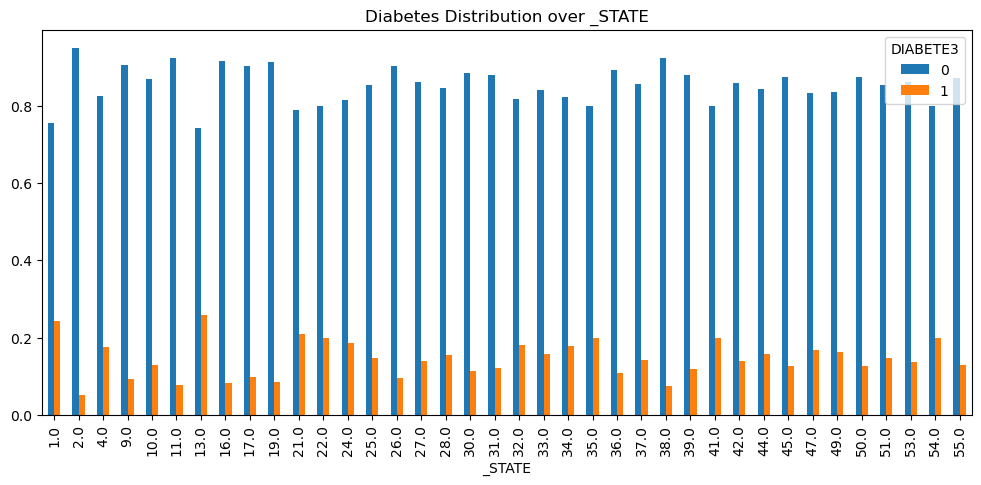

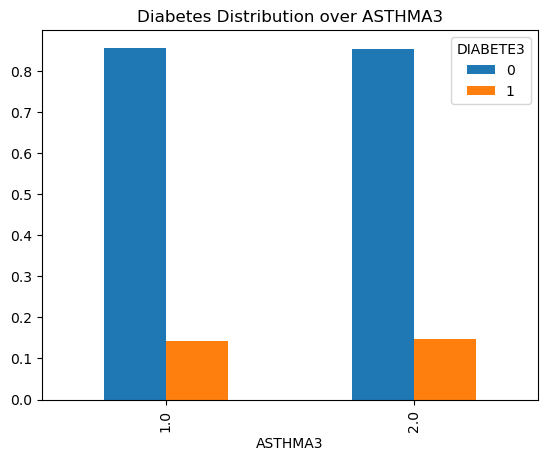

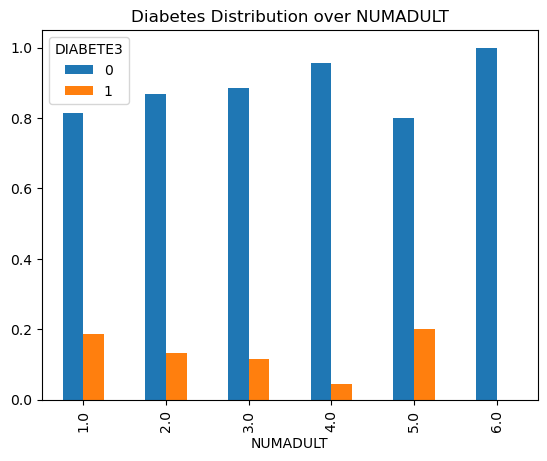

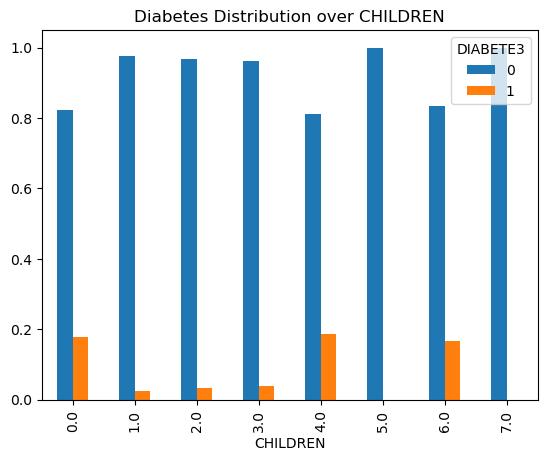

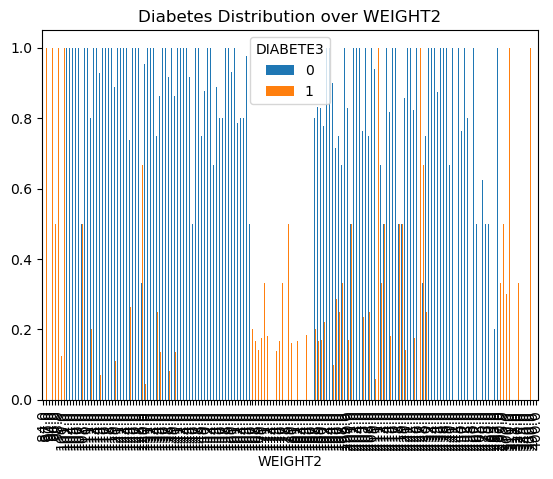

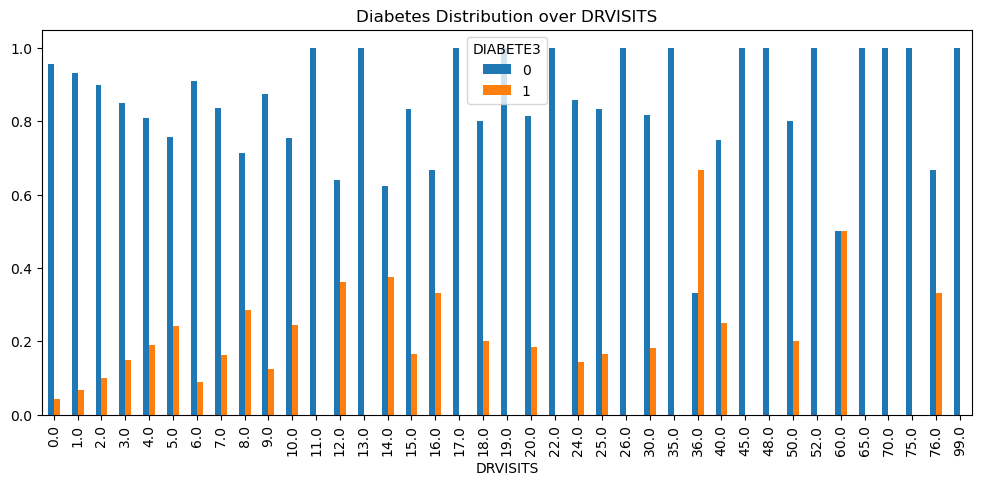

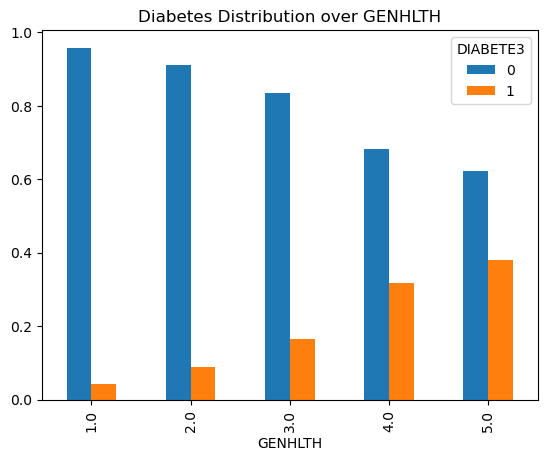

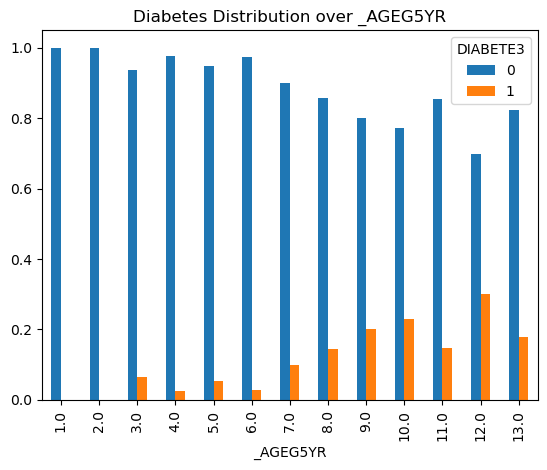

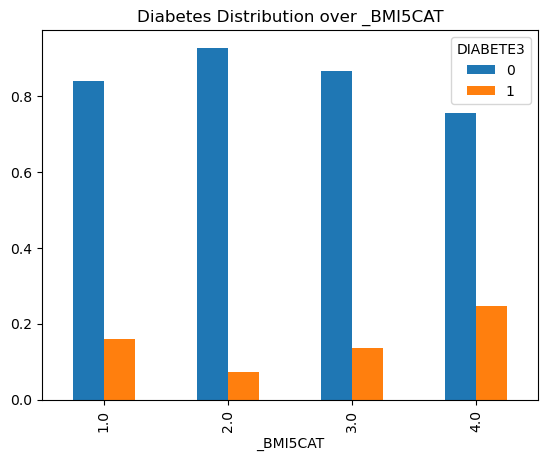

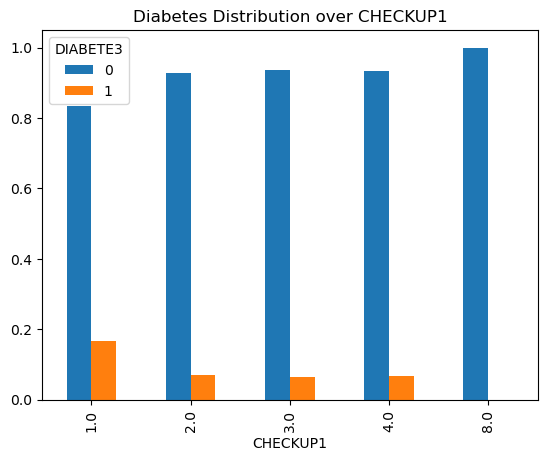

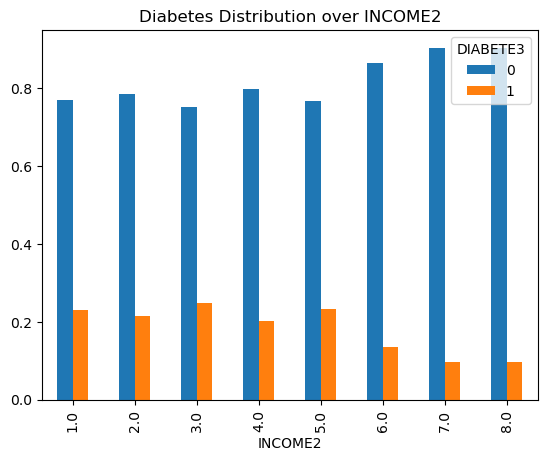

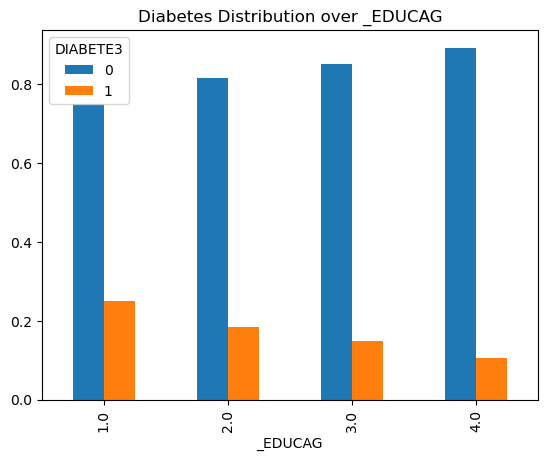

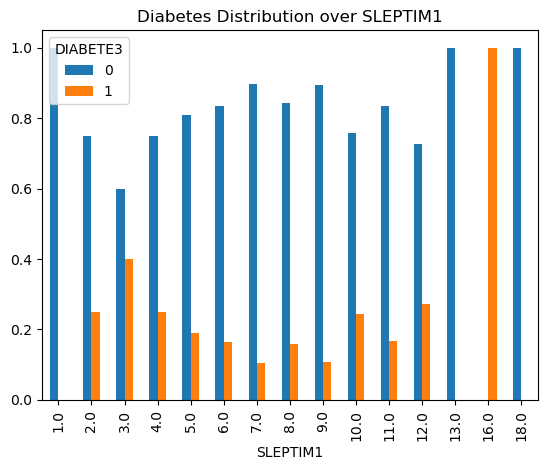

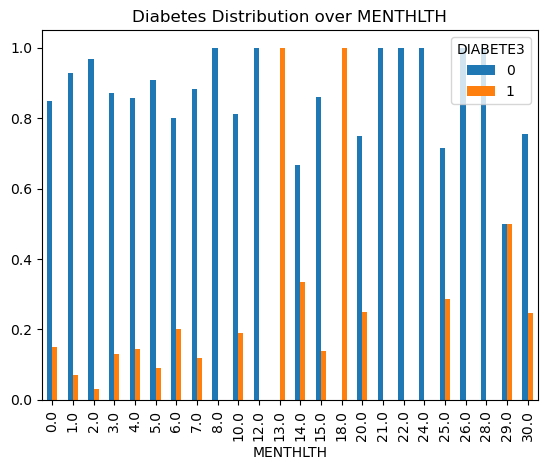

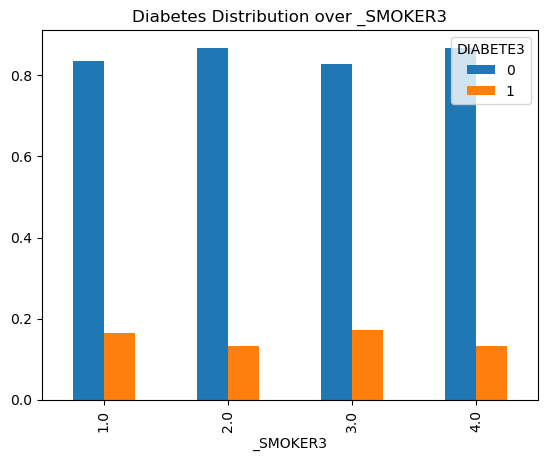

In [30]:
for v in variables:
    if v in custom_plots:
        graph(
            v,
            figsize=custom_plots[v].get("figsize"),
            labels=custom_plots[v].get("labels"),
        )
    else:
        graph(v)
        
        

## 2c. Justify your variable selection

Don't necessarily know how to do this part yet at this point. I just chose all the variables. Is there another way I should answer this question and choose my variables?

## Population Analysis

#### Notes

**Correlation:**

- If a correlation value is negative or very low, it indicates a weak relationship with DIABETE3. For example, _RACE has a negative value, suggesting a weak relationship, so consider dropping _RACE as a variable. However, later on, it's observed that all independent variables have a weak relationship to the target, so it's wiser to instead observe relationships to DIABETE3 with combined features.

- A negative relationship implies an inverse correlation, while a positive relationship means that as one variable increases, the other also increases. If there's no relationship, there isn't a set rule for what happens to the other variable.

- The range of the correlation coefficient (\(r\)) is -1 to 1, where:
  - \(r = 1\): Perfect positive relationship
  - \(0.5 < r < 1\): Strong positive relationship
  - \(0 < r \leq 0.5\): Weak positive relationship
  - \(-0.5 \leq r < 0\): Weak negative relationship
  - \(-1 < r < -0.5\): Strong negative relationship
  - \(r = -1\): Perfect negative relationship
  - \(r = 0\): No relationship

- A variable can **only** have a perfect relationship to another variable if compared to itself.

- When using `corr()`, all variables need to be the same length. It cannot work on categorical and numeric types simultaneously. Therefore, run `corr()` when all features are of the same type.

*Refer to the correlation formula for a detailed understanding.*

**Population Analysis:**

- The dataset has a relatively small number of variables compared to the number of entries.

- Overfitting occurs when there are few variables and many entries, leading the model to capture noise instead of true patterns. Underfitting is the opposite, where the model is too simple to capture the underlying patterns.

- Conduct population analysis to identify variables with weak relationships to the target variable (DIABETE3). In a large dataset, it's acceptable to drop these variables to reduce bias and improve model performance.

- Building the model with only the most significant variables helps prevent overfitting and enhances the model's generalizability.


#### Correlation Diagrams

In [ ]:
corr = alldf_tmp.corr()
corr

In [ ]:
plt.figure(figsize=(35, 20))

cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, linewidths=0.1)
plt.show()

In [ ]:
corr["DIABETE3"]

**Observations**

The independent variables exhibit a modest association with diabetes, as indicated by correlation coefficients (r) falling within the range of -.5<=r<0 or 0<r<=0.5. Consequently, it becomes essential to evaluate the collective relationships among the features of the independent variables in connection to diabetes. None of the variables independently can explain the target variable

#### Feature Engineering  
creating new features from highly correlated features

In [ ]:
def get_correlated_features(feature="DIABETE3", corr=corr):
    """
    Given a feature name, get the features with a strong and weak or negligible correlation to it.
    """

    correlation_dict = corr[feature].to_dict()
    weak_dict, strong_dict = {}, {}

    for f, r in correlation_dict.items():
        if -0.5 <= r <= 0.5:
            weak_dict[f] = r
        elif -1 <= r < 1: # no nan or 1 vals
            strong_dict[f] = r

    weak = sorted(weak_dict.items(), key=lambda x: x[1])
    strong = sorted(strong_dict.items(), key=lambda x: x[1], reverse=True)

    return weak, strong

In [ ]:
strong_correlations = []

for col in alldf_new.columns:
    _, strong = get_correlated_features(col)

    strong_correlations.extend([(col, f, v) for f, v in strong])

strong_correlations

I derived that the strongest correlations are between the following:
- EMPLOY1 and AGEG5YR have a strong positive correlation where r = 0.556
- CHILDREN and _AGEG5YR have a strong negative correlation where r = -0.526.
- WEIGHT2 and _BMI5CAT have a strong positive correlation where r = 0.751. 

**Therefore, these are the variables I choose along with the target variable, DIABETE3.**

sns.countplot is great for plotting two categorical variables. 
- If dodge is set to True, the bars corresponding to different categories of the hue variable will be plotted adjacent to each other. 
- Example: the graph below for age vs employment, the bars for each color within an age group show the count of individuals with that specific employment status in that age group.

In [ ]:
# 0.555511 (strong positive correlation)

plt.figure(figsize=(10, 5))
sns.countplot(x="_AGEG5YR", hue="EMPLOY1", data=alldf_new, dodge=False)
plt.show()

In [ ]:
# -0.053873 (weak negative correlation)
sns.catplot(alldf_new, x="EMPLOY1", y="DRVISITS")

# 3

## 3a. Clean the dataset to handle any missing data

Look at part 1

## 3b. Justify your decisions

I wanted to drop all NA values because those represented BLANK, which corresponds with missing values. Additionally, I decided to get rid of values that correspond to "refused" and "do not know/not sure" because I felt that simplifying the dataset to only include entries where respondents gave clear answers was important for training my model.

# 4

##### 4a. For building a model, would you rescale any data in this dataset? **How** and **why or why not**?

If I were using k-nearest neighbors (knn), gradient descent-based algorithms, principal component analysis, or regularization techniques I would rescale since those models/algorithms are sensitive to feature scales. For instance, distance-based algorithms like knn rely on the distance between data points, so a major difference in scale can lead to greater distances which can dominate distance calculations. So rescaling some features could improve convergence and diminish bias amongst features. The way I would rescale is by standardizing or normalizing the data for features with a major range such as WEIGHT2 since pounds can go from 50-999 and similarly kilograms 9000-9998.

However, I wouldn't need to rescale if I use a tree-based model such as decision trees, random forests, or gradient boosting methods since they're typically insensitive to features' scales. For example, decision trees rely on feature thresholds, which is impartial to the scale of those features.

In my case, I chose to use XGBoosting and also tried regular Gradient Boosting, particularly the classification model version. Therefore, I don't need to rescale as mentioned prior. 

Nonetheless, I will still address the imbalanced nature of my dataset regardless of the model used since I want to mitigate bias to the majority class. I learned by graphing the diabetes distribution there's an overwhelming number of people without diabetes to those with. To resolve this imbalance, I can perform random or synthetic oversampling methods.

Furthermore, for the WEIGHT2 feature, unifying the units to a single metric, such as pounds will help because the model won't recognize the difference between pounds and kilograms. For the target variable DIABETE3, adopting a binary representation where 1 indicates a positive diagnosis of diabetes and 0 signifies the absence of a diabetes diagnosis aligns with my goal of binary classification in the modeling process.

# 5

## 5a Build a model to identify risk factors for diabetes. 

## 5b Explain your choice of model and what it can predict. 

## 5c What metrics would you use to assess performance? 

## 5d For this dataset, how would you know your model is adequate?

In [ ]:
# separate target and independent variables
y = alldf_tmp["DIABETE3"] 
X = alldf_tmp.drop(columns="DIABETE3") 

In [ ]:
# address imbalance in the dataset

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)

X, y = smote.fit_resample(X, y)

In [ ]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

model = XGBClassifier()

# cross validation version
kf = KFold(n_splits=5)
avg_model_scores = np.mean(cross_val_score(model, X, y, cv=kf))
print(avg_model_scores)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cr = classification_report(y_test, y_pred)
print(cr)

In [31]:
feature_importances = model.feature_importances_
for feature, importance in sorted(zip(X.columns, feature_importances), key=lambda x: x[1], reverse=True):
  print(f"{feature}: {importance}")

NameError: name 'model' is not defined

# 6. Using these data, what are some identifiable risk factors for diabetes? How do you know? Explain as if you were reporting the results to a non-technical stakeholder.

The most important features are 

GENHLTH: 0.16922499239444733
_TOTINDA: 0.07415896654129028
CHILDREN: 0.07380124181509018
_BMI5CAT: 0.07154451310634613
BLIND: 0.05338083207607269
CVDCRHD4: 0.050223458558321

The least important are:

WEIGHT2: 0.010020529851317406
PERSONID: 0.00973158422857523
MARITAL: 0.009483946487307549
_STATE: 0.008029725402593613
EXERANY2: 0.0
HLTHPLN1: 0.0